# Introduction

This notebook is based on the Kaggle kernel by mnassrib (https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python/data).

Like all regression analyses, the logistic regression is a predictive analysis. However, despite the name logistic *regression*, it is actually a method for doing (two-class) *classification* of a binary target variable.

The aim is to predict the _probability_ of an observation to belong a class (C1 - yes/ C0 - no), given the input features $x$:  $p(C_1|x)=y(x)$. We will introduce some theoretical background of logistic regression in this notebook and then do classification by predicting survival using the Titanic dataset.

But first let's look into some details of logistic regression...

In [1]:
import pandas as pd
movie = pd.read_csv('./data/movie.csv')

## A toy dataset to see how logistic regression works

We have a small dataset, that we will use to explain the idea of logistic regression. Let's assume we asked a few people that just came out of a cinema how old they are and if they liked the movie "XYZ". Then we will see if we can predict if someone will like the movie if we know the person's age. This is how our data look like:

![](./img/movie-scatter.svg)

So, the older people are the less they seem to enojoy the movie.

### Logistic regression, a simplified explanation
What could we do to predict if someone of a given age will like the movie? We could fit a linear regression. The result would look similar to this:

![](./img/movie-linear.svg)

There is a problem here. The linear regression predicts a continuous outcome y that can take any value between $-\infty$ and $\infty$. But what we want to predict is a binary outcome: We have two classes, people that liked the movie (y=1) and people that didn't like it (y=0). So linear regression is obviously not the best choice to model this problem.


A simple solution: We use a threshold on the age variable and classify anything that is below this cutoff value for y as 1 and the rest as 0. It could look like that: 

![](./img/movie-threshold.svg)

Although this looks like a good idea, this model is hard to optimize numerically (a threshold is not a differentiable function, it is not even continuous). Additionally, we can't really see how certain the model is in its decision. 

Here's a better idea: We will use a smooth (and differentiable) function that produces something like a smoothed threshold (and squashes the values of the regression between [0,1]). The we could interpret the result as a probability: the probability of liking the movie $y$, given the age $x$: $P("likes movie"|x)$. A good nonlinear function to use is the logistic sigmoid:

![](https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg)

It has everything we need: it maps values from $(-\infty, \infty)$ to $(0,1)$, and it is smooth and differentiable. Nice...

If we use this function and fit it to our data, the result looks like this:
![](./img/movie-logistic.svg)

We give the model the age and it will predict the probability of liking the movie. That is the basic idea of logistic regression. So we get a probability and then we can threshold it to get a classification, or use the probability as it is (e.g. in a Bayesian analysis). 

### A bit more mathematical explanation

So why the logistic function? There is a deeper relation here. Let's start a bit more abstract. We need a function that takes the value x (the person is x years old) and outputs a probability $p("liked movie"|x)$ (e.g. the person likes the movie). And we want to have a linear relationship between our explanatory variable $x$ and the prediction $p("liked movie"|x)=y(w_1 x + w_0)$. We cannot predict a probability directly because a valid probability needs to lie in the range $[0,1]$, but we could predict the odds (https://en.wikipedia.org/wiki/Odds), the ratio of the probability to like the movie to the probability of not liking it: $\frac{p("likes movie")}{p("doesnt like movie")}=\frac{p("likes movie")}{1-p("likes movie")}$. This ratio lies in the interval $(0,\infty)$, so we are getting closer, but we still cannot really predict it from a linear model, that outputs any real number (not just those $\geq 0$). 

If we now just take the log of the odds (the _logit_): $\log(\frac{p("likes movie")}{1-p("likes movie")})$ we have some measure that lies in the range $(-\infty,\infty)$ and that we could nicely predict with a linear model: $\log(\frac{p("likes movie"|w_1 x + w_0)}{1-p("likes movie"|w_1 x + w_0)}) = w_1 x + w_0$. All we need is a function $\sigma$ that satisfies the relation $\log(\frac{\sigma(w_1 x + w_0)}{1-\sigma(w_1 x + w_0)}) = w_1 x + w_0$. There is indeed a function with this property: the logistic sigmoid: $\sigma(v)=\frac{1}{1+\exp(-v)}$. You can see that it works by substituting the definition of the sigmoid into $\log(\frac{\sigma(w_1 x + w_0)}{1-\sigma(w_1 x + w_0)}) = w_1 x + w_0$.

So the sigmoid is exactly the nonlinear function that we need to use a linear regression model of the data and transform the outcome into a probability, so we can do prediction. In statistics, this nonlinear function is called the _link function_ and there is a particular link function for different problems. As we have seen, for binary classification, the link is the logistic sigmoid, for multi-class classification the link function will turn out to be the softmax. For those of you who worked with artificial neural networks before: This property of is exactly the reason why the sigmoid is used as the nonlinear activation function for binary classification problems. 

## A probabilistic view on classification

We have a two-class classification problem, i.e. an observations falls into $C_1$ or $C_0$.
We can use the class-conditional densities $p(x|C_k)$ and the class prior probabilities $p(C_k)$ to compute the posterior probabilities of the class given the observation using Bayes' theorem: 
$$p(C_1|x) = \frac{p(x|C_1)p(C_1)}{p(x|C_1)p(C_1)+p(x|C_0)p(C_0)}.$$

If we now define $o$ to be $$o(x) = \log \frac{p(x|C_1)p(C_1)}{p(x|C_0)p(C_0)} = \log \frac{p(x|C_1)p(C_1)}{1- p(x|C_1)p(C_1)}$$, and that means $o$ is simply the log odds, then we get: 
$$ p(C_1|x) = \frac{1}{1+exp(-o)}$$ and this is indeed just the logistic sigmoid function $\sigma(o)$. And indeed, its inverse is just the logit (log odds) function : $$o(\sigma) = \log \frac{\sigma}{1-\sigma}.$$

So if we model the log odds $o(x)$ as a linear function of the features $x$, we get a generalized linear model. So we compute a linear model of the inputs and use the sigmoid as a nonlinear function (called the activation function in neural networks) and end up with logistic regression. The name might be a bit confusing, as we actually used it for classification, but we are predicting a probability (a continuous outcome), so the name is not wrong... 

## Assumptions for logistic regression

- the outcome y to be predicted is a binary variable (yes/no)
    - (y = 1 typically present the desired case.)
- The features or covariates $x$ should be independent, i.e. there is no multicollinearity (or as little at possible).
- the features $x$ are linearly related to log odds
- we need a large sample sizes, i.e. you need at least 10 cases for the least likely outcome (see http://www.statisticssolutions.com/assumptions-of-logistic-regression/)

# Doing Logistic Regression

Let's try logistic regression on some real data...

## The Titanic Data set

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

### Overview
The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

### Data Dictionary

Variable | Definition | Key
---|---|---
survival|Survival|0 = No, 1 = Yes
pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd
sex|Sex|
Age|Age in years|
sibsp|# of siblings / spouses aboard the Titanic|
parch|# of parents / children aboard the Titanic|
ticket|Ticket number|
fare|Passenger fare|
cabin|Cabin number|
embarked|Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton|

### Variable Notes

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

<a id="t1."></a>
# 1. Import Data & Python Packages

In [1]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

We will read the data from a csv file into a pandas DataFrame. We only use the training data from the Kaggle competition as the test set doesn't have the target values.


In [2]:
train_df = pd.read_csv("./data/train.csv")

# preview the data organization
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print('The number of samples in the train data is {}.'.format(train_df.shape[0]))

The number of samples in the train data is 891.


<a id="t2."></a>
# 2. Data Quality & Missing Value Assessment

First we will check the quality of the data, and the most important aspect are missing entries. 

In [4]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

So we have quite a few missing values. Around 20% of entries have no value for "age", 77% of the entries have no "Cabin", and in two cases, the "embarked" information is missing. There are basically three strategies how you can deal with this problem: 
- use imputation to fill in the missing values with a reasonable guess or
- remove each observation (row) with missing values.
- remove the feature (column) with missing values from the entire dataset.

To keep it simple, we will remove the "cabin" feature completely, and also remove all observations, where "age" is missing (it is a useful feature if it is known, so we keep this feature). And we will just fill the two missing "embarked" entries with the most common value from the rest of the data (imputation).

However, another (better?) strategy is to use imputation for the "age" feature as well, as we wouldn't throw away ~20% of our observations. You could use the mean or median value to replace the missing values or you could sample it from a uniform distribution or from the data itself. We will leave this as an exercise. 

### Imputation for "embarked" missing values

Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: Embarked, dtype: int64


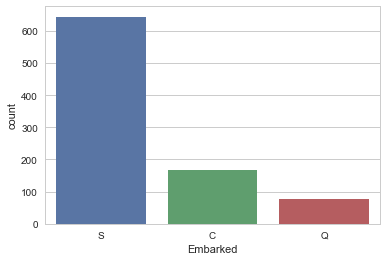

In [5]:
print('Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(train_df['Embarked'].value_counts())
sns.countplot(x='Embarked', data=train_df)
plt.show()

Most passengers boarded in Southhampton, so we'll use this value ("S") to fill the missing values.

## cleaning up the data  

We will now remove the rows (observations) with missing "age" value.

In [6]:
train_data = train_df.copy()
#train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
train_data=train_data.dropna(subset=["Age"])

We will get rid off the 'cabin' column (feature) entirely.

In [7]:
train_data.drop('Cabin', axis=1, inplace=True)

And we will impute the missing 'embarked' information.

In [8]:
train_data["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace=True)

and check if it worked...

In [9]:
# check missing values in adjusted train data
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### creating dummy variables for categorical features

It is good practice to encode some categorical variables into dummy variables (using only 0 and 1). see here: https://en.wikipedia.org/wiki/Dummy_variable_(statistics).

We'll create dummy variables for the port where the journey began ("Embarked") and for the "Sex" variable.

In [10]:
#create categorical variables and drop some variables
training=pd.get_dummies(train_data, columns=["Embarked","Sex"])
training.drop('Sex_male', axis=1, inplace=True)

To keep it simpler, we'll drop the features "name", "passengerID", and "ticket" as they are not obviously predictive for survival. Although you might still be able to infer something interesting from this information.

In [11]:
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)
final_train = training

If you are interested in further ideas of how to transform the data, have a look at the examples here: http://www.ultravioletanalytics.com/blog/kaggle-titanic-competition-part-i-intro

## Add additional (derived) features

Here you could use some of the existing information and add some new features (or replace old ones with them). For example, you could remove the 'SibSp' (traveling with siblings or spouses) and 'Parch' (traveling with parents or children) and introduce a new binary feature like 'travelingAlone', see the commented code below. Just as an idea. 

In [12]:
## Create categorical variable for traveling alone
# train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
# train_data.drop('SibSp', axis=1, inplace=True)
# train_data.drop('Parch', axis=1, inplace=True)

## Exploratory Data Analysis

This is how our final data set looks like:

In [13]:
final_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female
0,0,3,22.0,1,0,7.2500,0,0,1,0
1,1,1,38.0,1,0,71.2833,1,0,0,1
2,1,3,26.0,0,0,7.9250,0,0,1,1
3,1,1,35.0,1,0,53.1000,0,0,1,1
4,0,3,35.0,0,0,8.0500,0,0,1,0


Now it is a good idea to plot the distribution of some features and also look into correlations between features to decide, which you want to keep in the regression analysis.

### plotting the distributions

In [14]:
def plot_numerical(feature): 
    plt.figure(figsize=(15,8))
    p1=sns.distplot(final_train[feature][final_train.Survived == 1], kde=False)
    p2=sns.distplot(final_train[feature][final_train.Survived == 0], kde=False)
    plt.legend(['Survived', 'Died'])
    ax=p1.axes
    ax.set(xlabel=feature)
    plt.show()
    
def plot_categorical(feature):
    plt.figure()
    sns.barplot(feature, 'Survived', data=final_train)
    plt.show()

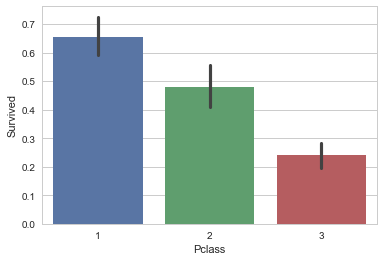

In [15]:
plot_categorical("Pclass")

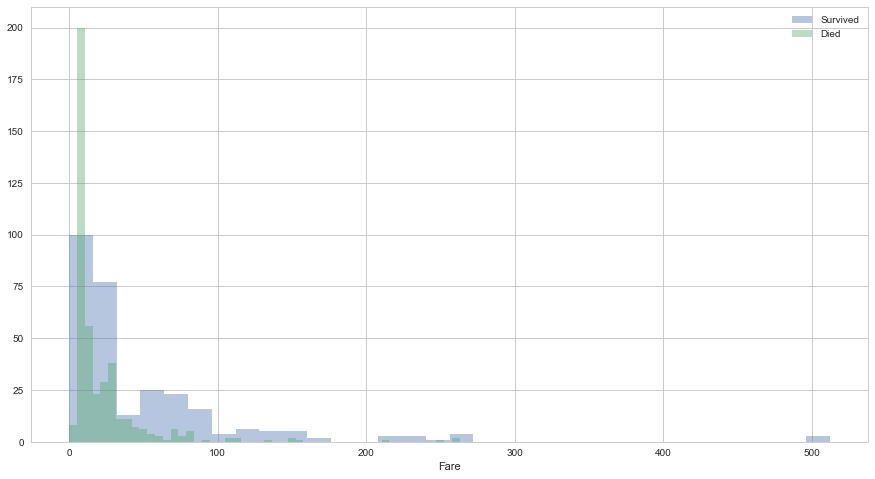

In [16]:
plot_numerical("Fare")

Now you can explore the features and then think about which ones you would like to include into the model. We will later show a way to use automated methods for feature selection. But it is still good practice to explore your data first, before you blindly rely on computational results (see https://en.wikipedia.org/wiki/Anscombe%27s_quartet and even more impressive here: https://www.autodeskresearch.com/publications/samestats). 

<a id="t4."></a>
# 4. Logistic Regression and Results

## Compute a simple model

Now we are ready to fit a logistic regression model to the data. In the code below we will use "age" and "fare" to predict survival. Keep in mind that Machine Learning is not (only) optimization, instead of searching for a perfect fit to the training data we want to be able to predict unseen observation. To analyze the performance of the logistic regression model, we thus split the data again into a training set and a test set. We optimize the parameters using the observations from the training set. We then use the observations from the test set to validate how well our method can generalize to 'new' data. There are several ways to approach this, you will find different measures below...

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression


# create X (features) and y (response)
Selected_features = ["Age","Fare","Sex_female"] 
X = final_train[Selected_features]
y = final_train['Survived']

# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

/Users/scherf/miniconda3/envs/presentation/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Methods to quantify the performance of the classifier

### Accuracy

The simplest approach: Train the classfier on the training data and predict the obervations from the test set. Then we will look at the accuracy.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg=LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

predicting the test set

In [19]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression on test set: {:.2f}'.format(logreg.score(X_test,y_test)))

Accuracy of logistic regression on test set: 0.79


### Cross Validation

We can use [Cross Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) to get an average estimate of how our model perfoms. We will use 10 fold Cross Validation to test the model, i.e. we split the data into 10 subsets, and then use 9 sets for training and predict the 10th set. This procedure will be iterated for all 10 subsets and finally we compute the average accuracy.

In [20]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10,random_state=7)
modelCV = LogisticRegression()
scoring='accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.774


### Confusion matrix

A good way to visualize the performance is by looking at the confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix). It shows for each class (rows) of the observation, which class the model has predicted, i.e. ideally we only have nonzero entries at the diagonal (where actual class = predicted class). 

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[105  20]
 [ 26  64]]


### Precision, Recall, F-score, and support

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_test.

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.84      0.82       125
          1       0.76      0.71      0.74        90

avg / total       0.78      0.79      0.78       215



### ROC curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).
You'll find more information here https://en.wikipedia.org/wiki/Receiver_operating_characteristic. Below you will find the code to plot the curve. The area under the ROC curve will give us a single measure of performance. The closer "logit_roc_auc" is to 1, the better our predictions are. (A simple explanation can be found here: https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/) 

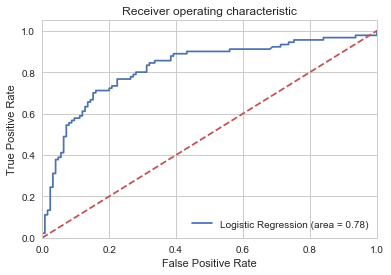

In [23]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Your turn

OK. So we have around 60% accuracy with the two features "age" and "fare". But we can do better of course. Now you should go back to the point 4 above and change the "Selected_features" variable to include the features you would want to test as predictors. Below you will find the code to plot the correlation between the features. The correlation is something you may want to think about when you decide which features to include...

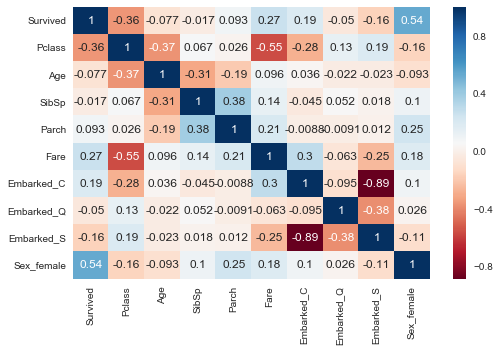

In [24]:
X = final_train

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap='RdBu')
plt.show()


## Automated Feature selection

Recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a `coef_ attribute` or through a `feature_importances_` attribute. Then, the least important features are removed from current set of features. The procedure is recursively repeated on the reduced set until the desired number of features to select is reached (here we used 4 but you can change that...).

http://scikit-learn.org/stable/modules/feature_selection.html

In [25]:
all_features=list(final_train.columns)[1:]
all_features

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Sex_female']

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = all_features 
X = final_train[cols]
y = final_train['Survived']
# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 4 attributes
rfe = RFE(model, 4)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['Pclass', 'Embarked_C', 'Embarked_Q', 'Sex_female']


### Feature ranking with recursive feature elimination and cross-validation

There is another (and probably) better way than selecting the number of features to include beforehand. It is calles recursive feature elimination and cross validation. RFECV performs RFE in a cross-validation loop to find the optimal number or the best number of features. This automatically tunes the number of features.

Optimal number of features: 8
Selected features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female']


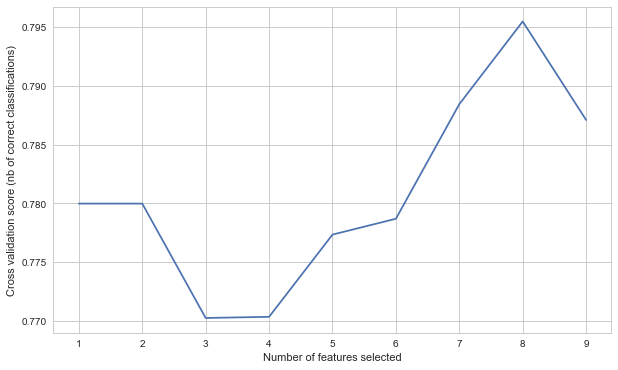

In [27]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

As we see, eight variables (all but one) were kept. The "Fare" feature did not make it in the final list. Do you have an idea why?

In [28]:
Selected_features=list(X.columns[rfecv.support_])

In [31]:
X = final_train[Selected_features]
y = final_train['Survived']

# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model=logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.84      0.76      0.80        93
          1       0.62      0.72      0.67        50

avg / total       0.76      0.75      0.75       143



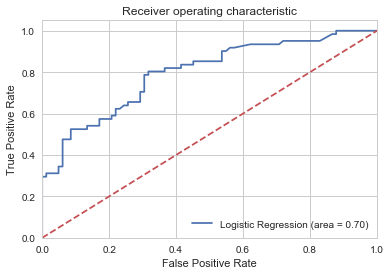

In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [38]:
model.coef_

array([[-1.1248621 , -0.03942712, -0.22162882, -0.02506249,  1.15861462,
         0.02525477,  0.605339  ,  2.51692205]])

If you are not yet satisfied with the results, you can go back and change the way we've dealt with missing values in the 'age' column, or you could add other features. If you need inspiration, have a look at this site: http://www.ultravioletanalytics.com/blog/kaggle-titanic-competition-part-i-intro

So this is the end of this notebook, I hope you've learned something useful about Logistic Regression and thanks a lot for you time.